In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
X_train = pd.read_csv("data/cleaned_data/X_train.csv")
X_test = pd.read_csv("data/cleaned_data/X_test.csv")
y_train = pd.read_csv("data/cleaned_data/y_train.csv")
y_test = pd.read_csv("data/cleaned_data/y_test.csv")

In [3]:
X_train = X_train.drop(columns = {"Unnamed: 0"})
y_train = y_train.drop(columns = {"Unnamed: 0"})
X_test = X_test.drop(columns = {"Unnamed: 0"})
y_test = y_test.drop(columns = {"Unnamed: 0"})

In [4]:
print("X_train.shape : " , X_train.shape)
print("X_test.shape : " , X_test.shape)
print("y_train.shape : " , y_train.shape)
print("y_test.shape : " , y_test.shape)

X_train.shape :  (7887, 16)
X_test.shape :  (2630, 16)
y_train.shape :  (7887, 2)
y_test.shape :  (2630, 2)


## Model Creation
### RandomForest With MultiOutput Prediction

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import RegressorChain
model = RandomForestRegressor(random_state = 1)
wrapper = RegressorChain(model, order=[1,0])
wrapper.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(random_state=1),
               order=[1, 0])

In [6]:
y_pred = wrapper.predict(X_test)

In [7]:
from sklearn import metrics
print('MAE:', metrics.mean_squared_error(y_test, y_pred))

MAE: 1627607.9374665248


In [8]:
metrics.r2_score(y_test, y_pred)

0.7497330353763738

### Model Validation
#### RandomnizedSearchCv

It's very fast and detects the best potential parameters.This parameters are not our final parameters for our model and we have to get the final parameters with `GridSearchCV`.

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10 , 5)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4,6]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
              }
print(random_grid)

{'n_estimators': [200, 288, 377, 466, 555, 644, 733, 822, 911, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [1, 3, 5, 7, 10], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 6]}


In [11]:
model = RandomForestRegressor(random_state = 1)
model_cv = RandomizedSearchCV(estimator = model , param_distributions = random_grid,
                                cv = 5 , verbose = True , random_state = 1 , n_jobs = -1)

model_cv.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
                   n_jobs=-1,
                   param_distributions={'max_depth': [1, 3, 5, 7, 10],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [2, 4, 6],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]},
                   random_state=1, verbose=True)

In [12]:
param_grid = {
    "max_depth": [model_cv.best_params_['max_depth']],
    "max_features": [model_cv.best_params_['max_features']],
    'min_samples_leaf': [model_cv.best_params_['min_samples_leaf'], 
                         model_cv.best_params_['min_samples_leaf'] + 2],
    'min_samples_split': [model_cv.best_params_['min_samples_split'] - 1,
                          model_cv.best_params_['min_samples_split'], 
                          model_cv.best_params_['min_samples_split'] + 1],
    'n_estimators': [model_cv.best_params_['n_estimators'] - 100, 
                     model_cv.best_params_['n_estimators'], 
                     model_cv.best_params_['n_estimators'] + 100]
}
print(param_grid)

{'max_depth': [10], 'max_features': ['auto'], 'min_samples_leaf': [2, 4], 'min_samples_split': [4, 5, 6], 'n_estimators': [633, 733, 833]}


In [13]:
model = RandomForestRegressor(random_state = 1)
grid_search = GridSearchCV(estimator = model,param_grid = param_grid , cv = 5 , n_jobs = -1 , verbose = True)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid={'max_depth': [10], 'max_features': ['auto'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': [4, 5, 6],
                         'n_estimators': [633, 733, 833]},
             verbose=True)

In [36]:
best_model = grid_search.best_estimator_
wrapper = RegressorChain(best_model, order=[1,0])
wrapper.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=10,
                                                    min_samples_leaf=2,
                                                    min_samples_split=6,
                                                    n_estimators=633,
                                                    random_state=1),
               order=[1, 0])

In [37]:
prediction = wrapper.predict(X_test)

In [38]:
print("Random Forest Mean Squared Error(MSE) On Test Set : " , round(metrics.mean_squared_error(y_test , prediction) , 2))

Random Forest Mean Squared Error(MSE) On Test Set :  1556487.06


### Cross-Validation
#### K-Fold Cross Validation

In [17]:
X = pd.concat([X_train , X_test] , axis = 0)
y = pd.concat([y_train , y_test] , axis = 0)

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kfold_cv = KFold(10 , shuffle=True)
mse_results = cross_val_score(wrapper , X , y , cv = kfold_cv , scoring='neg_mean_squared_error')
print(-1 * mse_results)

[1519727.20127245 1739483.1495158  1514004.93628747 1614933.67650165
 1256043.30889026 1621778.1935579  1768354.04845747 1489376.46908341
 1419334.15838476 1427055.47305279]


In [19]:
print("The mean of MSE scores is : " , -1 * (np.sum(mse_results) / mse_results.shape[0]))

The mean of MSE scores is :  1537009.0615003956


In [20]:
r2_results = cross_val_score(wrapper , X , y , cv = kfold_cv , scoring='r2')
print(r2_results)

[0.76004733 0.77269271 0.7811976  0.77737486 0.76624478 0.77939672
 0.74889602 0.75908279 0.76569649 0.76175356]


In [21]:
print("The mean of R2 scores is : " , (np.sum(r2_results) / r2_results.shape[0]))

The mean of R2 scores is :  0.7672382868201164


### Comparing The results with Ground Truth Values

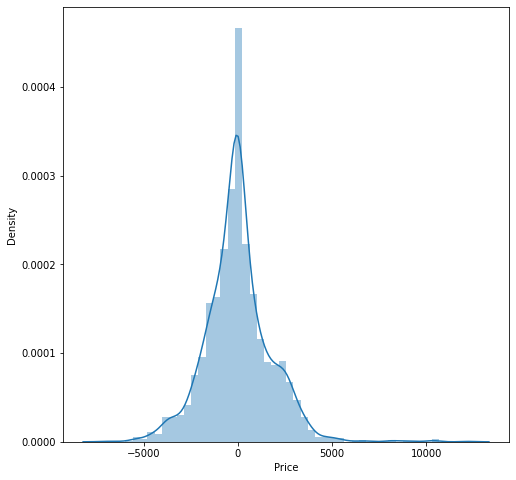

In [22]:
plt.figure(figsize=(8,8))
sns.distplot(y_test["Price"] - prediction[: , 1])
plt.show()

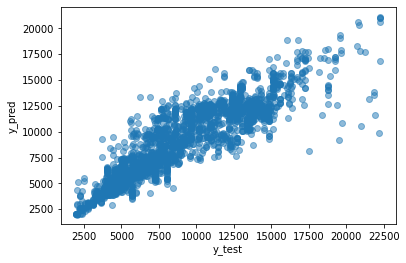

In [23]:
plt.scatter(y_test["Price"], prediction[: , 1] , alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

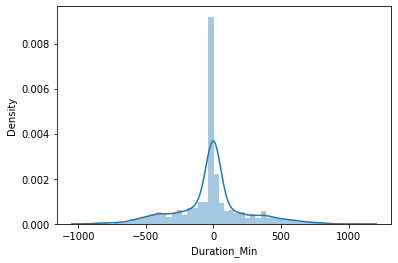

In [24]:
sns.distplot(y_test["Duration_Min"] - prediction[: , 0])
plt.show()

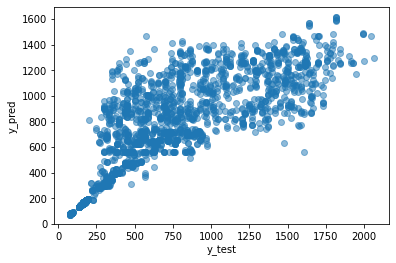

In [25]:
plt.scatter(y_test["Duration_Min"], prediction[: , 0] , alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

#### Saving The Model

In [44]:
model = RandomForestRegressor(max_depth=8, min_samples_leaf=2, min_samples_split=6, n_estimators=633, random_state=1)
wrapper = RegressorChain(model, order=[1,0])
wrapper.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=8,
                                                    min_samples_leaf=2,
                                                    min_samples_split=6,
                                                    n_estimators=633,
                                                    random_state=1),
               order=[1, 0])

In [45]:
prediction = wrapper.predict(X_test)

In [46]:
print("Random Forest Mean Squared Error(MSE) On Test Set : " , round(metrics.mean_squared_error(y_test , prediction) , 2))

Random Forest Mean Squared Error(MSE) On Test Set :  1829103.98


In [47]:
import pickle
file = open("model/flight-fare-prediction.pkl" , "wb")
pickle.dump(wrapper , file)